In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Using downloaded and verified file: ./data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Using downloaded and verified file: ./data\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Using downloaded and verified file: ./data\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 3923090.77it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [10]:
import matplotlib.pyplot as plt
import numpy as np

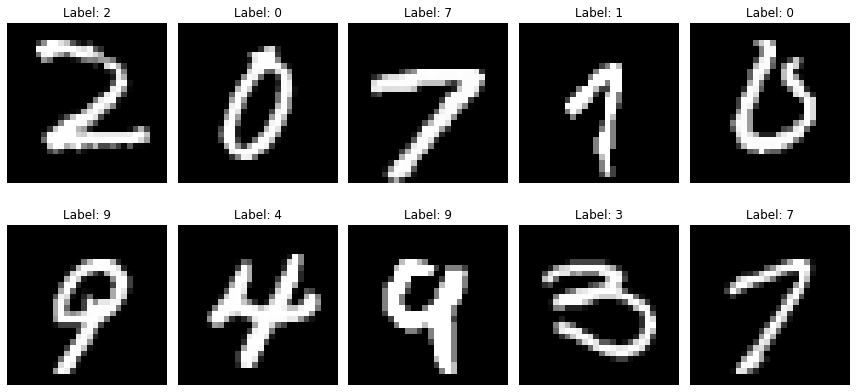

In [11]:
# Show some random samples from the training dataset
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    index = np.random.randint(len(train_dataset))
    image, label = train_dataset[index]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
# Define the architecture of the Pure CNN
class PureCNN(nn.Module):
    def __init__(self):
        super(PureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc(x)
        return x

In [13]:
# Create the model instance
model = PureCNN()

In [14]:
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 20490


In [15]:
# Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
# Set up the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PureCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [18]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

In [20]:
# Calculate training loss and accuracy
train_loss /= len(train_loader)
print('Epoch: {}, Training Loss: {:.4f}'.format(epoch+1, train_loss))

Epoch: 10, Training Loss: 0.0132


In [21]:
# Validation loop
model.eval()
val_loss = 0.0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()

In [32]:
# Calculate validation loss and accuracy
val_loss /= len(test_loader)
val_accuracy = correct / len(test_dataset)
print('Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, val_loss, val_accuracy * 100))

if val_accuracy >= 0.994:
    print('\n Target validation accuracy achieved!')

Epoch: 10, Validation Loss: 0.0000, Validation Accuracy: 98.68%


In [33]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [34]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [35]:
# Normalize pixel values to the range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

In [36]:
# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

In [37]:
# Define the architecture of the Pure CNN
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [38]:
# Print the model summary and count the number of parameters
model.summary()
total_params = model.count_params()
print("Total number of trainable parameters:", total_params)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 10)                8

In [39]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Training loop
batch_size = 64
num_epochs = 10
model.fit(train_images, train_labels, batch_size=batch_size, epochs=num_epochs)

Epoch 1/10
938/938 [==============================] - 20s 20ms/step - loss: 0.2685 - accuracy: 0.9236
Epoch 2/10
938/938 [==============================] - 18s 19ms/step - loss: 0.0811 - accuracy: 0.9757
Epoch 3/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0618 - accuracy: 0.9809
Epoch 4/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0513 - accuracy: 0.9840
Epoch 5/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0440 - accuracy: 0.9865
Epoch 6/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0379 - accuracy: 0.9879
Epoch 7/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0343 - accuracy: 0.9889
Epoch 8/10
938/938 [==============================] - 16s 18ms/step - loss: 0.0295 - accuracy: 0.9904
Epoch 9/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0264 - accuracy: 0.9916
Epoch 10/10
938/938 [==============================] - 17s 18ms/step - loss: 0.023

In [41]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

313/313 [==============================] - 3s 7ms/step - loss: 0.0382 - accuracy: 0.9881
Test Loss: 0.03816096484661102
Test Accuracy: 0.988099992275238
